<a href="https://colab.research.google.com/github/ivansabo/codigos_videos/blob/main/2025_atualizada_Carteira_Discricion%C3%A1ria_An%C3%A1lise_e_Comparativo_iSabo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Comparativo de Carteiras**
# Este script permite comparar diversas estratégias de alocação de portfólio:
# - **Discricionária**: pesos definidos pelo investidor.
# - **Simulação Monte Carlo**: 100.000 portfólios aleatórios para estimar a fronteira eficiente.
#   • **Menor Volatilidade**: portfólio com menor risco histórico.
#   • **Maior Sharpe**: melhor relação retorno x volatilidade.
#   • **Menor Correlação**: portfólio com ativos menos correlacionados.
# - Estratégias fixas:
#   • **Equal Weights**: pesos iguais.
#   • **Inverse Vol**: pesos proporcionais ao inverso da volatilidade.
#   • **Risk Parity:** pesos proporcionais ao inverso da variância (ignora correlação).
#   • **HRP: Hierarchical Risk Parity**, considera correlação hierarquicamente.
# O código baixa dados via yfinance, calcula métricas, gera gráficos (frontier, heatmaps, dendrograma) e exibe tabela com Retorno, Volatilidade, Sharpe e VaR 5%.

Quantas companhias (entre 2 e 20)? 5
Ticker #1: btc-usd
Ticker #2: vig
Ticker #3: fixa11.sa
Ticker #4: imab11.sa
Ticker #5: divo11.sa
Peso do ativo #1 (decimal, ex: 0.25): 0.2
Peso do ativo #2 (decimal, ex: 0.25): 0.2
Peso do ativo #3 (decimal, ex: 0.25): 0.2
Peso do ativo #4 (decimal, ex: 0.25): 0.2
Peso do ativo #5 (decimal, ex: 0.25): 0.2


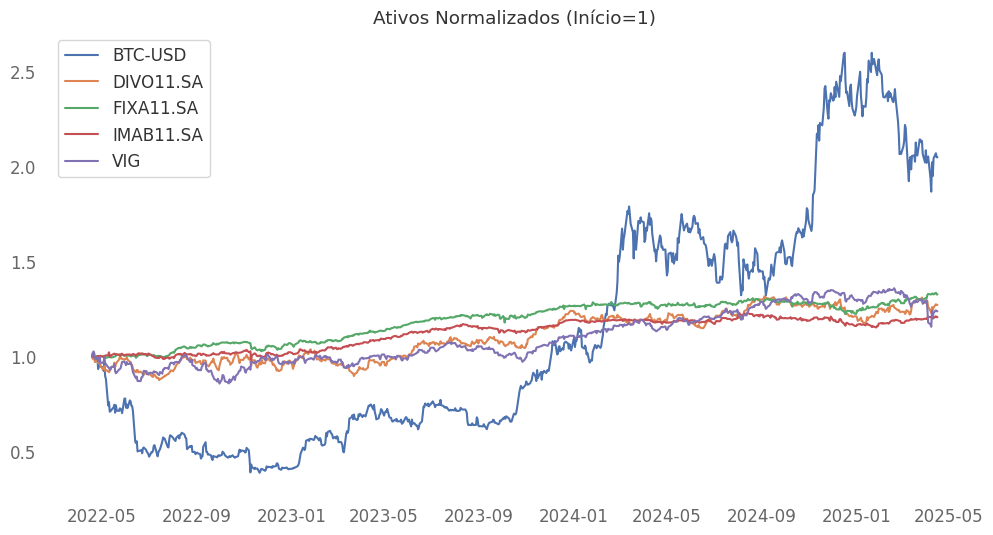

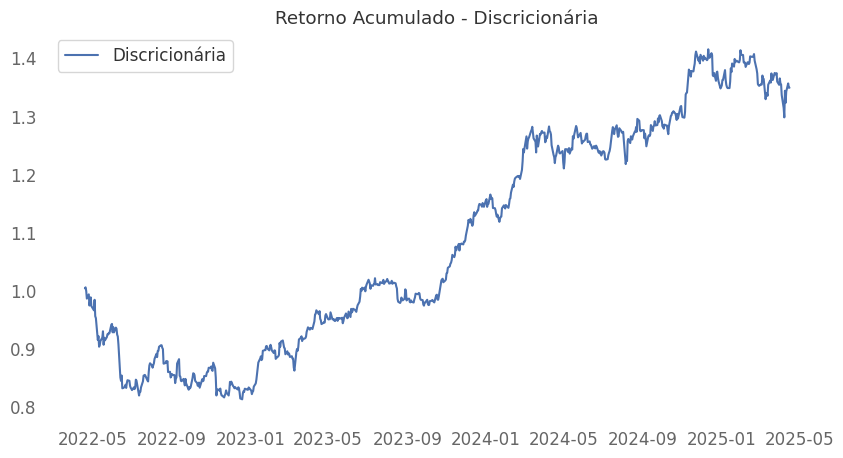

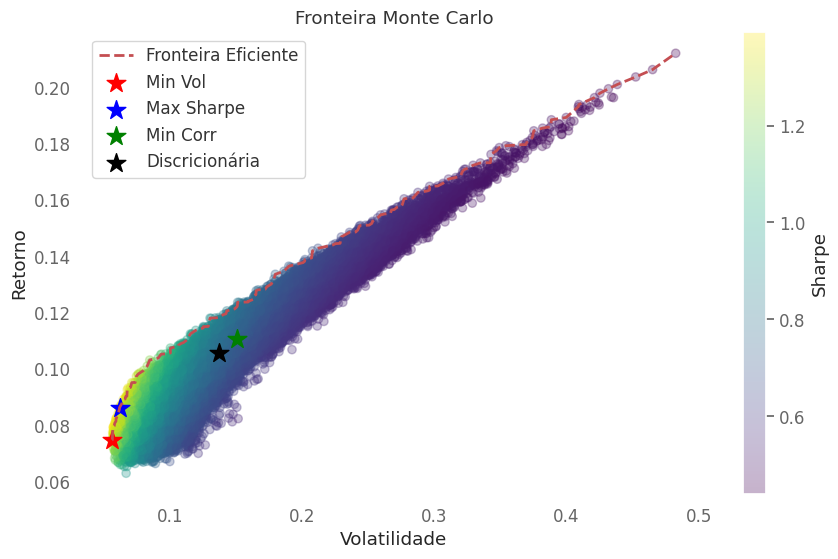

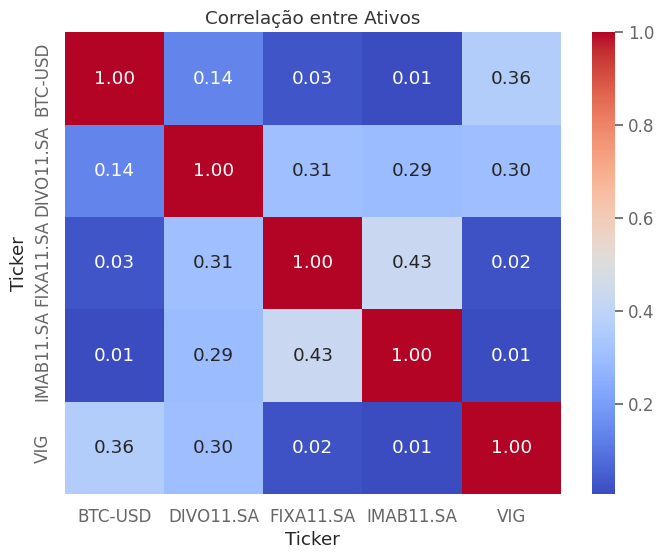

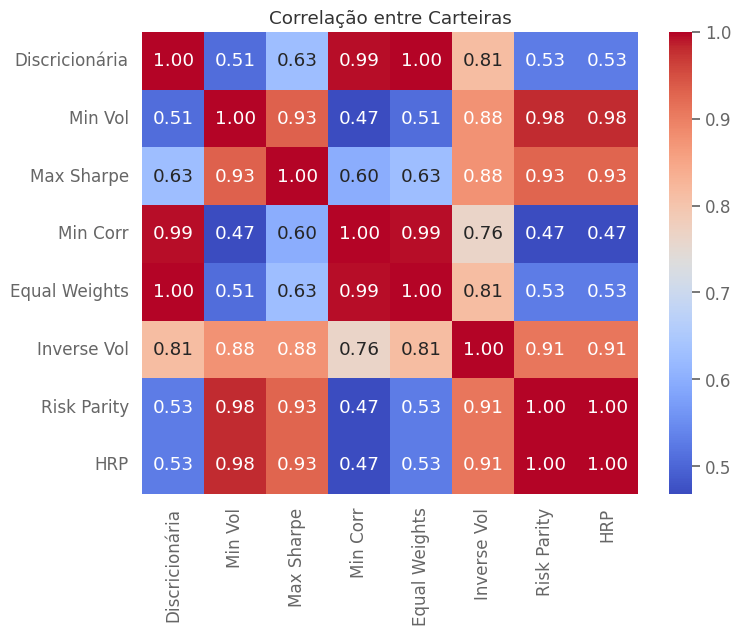

,BTC-USD,VIG,FIXA11.SA,IMAB11.SA,DIVO11.SA,Retorno,Volatilidade,Sharpe,VaR 5%
Carteira,,,,,,,,,
Discricionária,20.0%,20.0%,20.0%,20.0%,20.0%,10.58%,13.71%,0.77,-1.23%
Min Vol,0.7%,0.5%,39.1%,47.8%,11.8%,7.48%,5.64%,1.33,-0.58%
Max Sharpe,3.7%,1.0%,61.7%,28.2%,5.4%,8.63%,6.20%,1.39,-0.58%
Min Corr,23.4%,12.4%,20.4%,22.2%,21.6%,11.06%,15.12%,0.73,-1.34%
Equal Weights,20.0%,20.0%,20.0%,20.0%,20.0%,10.58%,13.71%,0.77,-1.23%
Inverse Vol,4.2%,15.3%,32.2%,33.1%,15.2%,8.15%,6.85%,1.19,-0.72%
Risk Parity,0.7%,8.9%,39.7%,41.9%,8.8%,7.61%,5.84%,1.30,-0.60%
HRP,0.7%,8.9%,39.7%,41.9%,8.8%,7.61%,5.84%,1.30,-0.60%


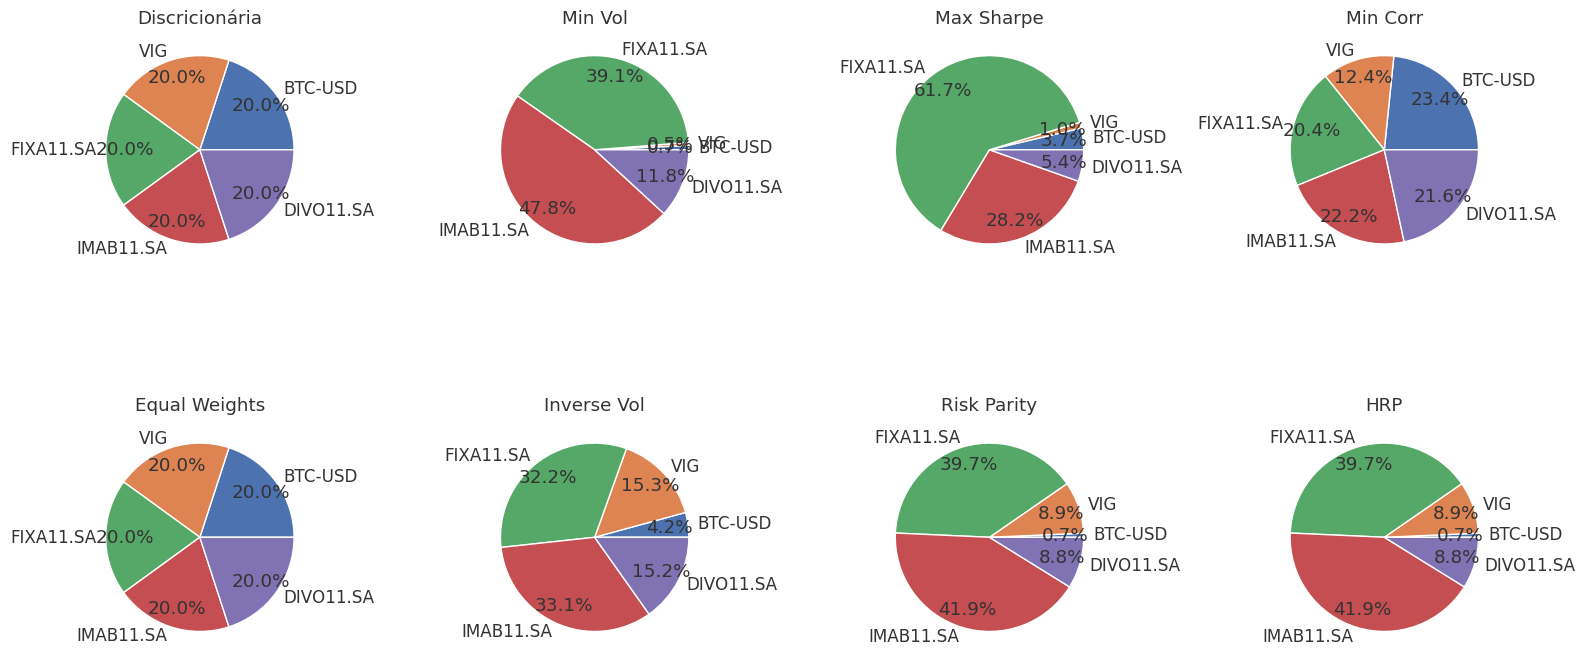

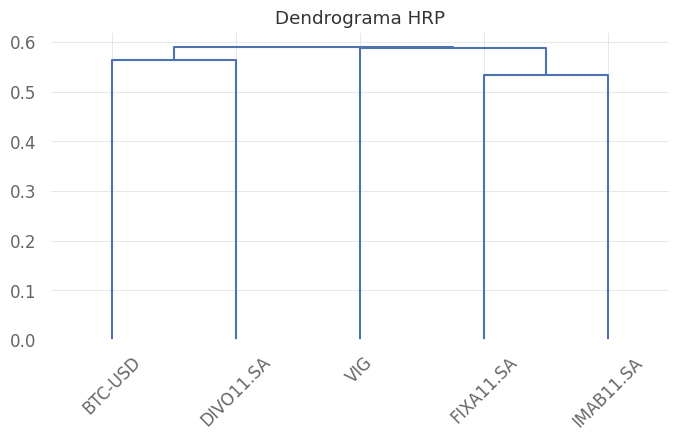


Value at Risk (VaR) a 5% indica a perda máxima esperada em condições normais com 95% de confiança.
Discricionária: -1.23%
Min Vol: -0.58%
Max Sharpe: -0.58%
Min Corr: -1.34%
Equal Weights: -1.23%
Inverse Vol: -0.72%
Risk Parity: -0.60%
HRP: -0.60%


In [60]:
# Instalação de pacotes (executar apenas no Colab)
!pip install --upgrade pandas_datareader yfinance scipy seaborn

# Imports
import math
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime
from scipy.optimize import minimize
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Captura interativa de tickers
def get_companies(min_assets=2, max_assets=20):
    while True:
        try:
            n = int(input(f"Quantas companhias (entre {min_assets} e {max_assets})? "))
            if min_assets <= n <= max_assets:
                break
            print("❌ Número inválido. Tente novamente.")
        except ValueError:
            print("❌ Entrada inválida. Digite um número inteiro.")
    companies = []
    for i in range(1, n + 1):
        while True:
            ticker = input(f"Ticker #{i}: ").strip().upper()
            if not ticker:
                print("❌ Ticker vazio. Tente novamente.")
                continue
            companies.append(ticker)
            break
    return companies

# 2) Captura e validação de pesos (um por vez)
def get_weights(n_assets):
    while True:
        pesos = []
        for i in range(n_assets):
            while True:
                try:
                    w = float(input(f"Peso do ativo #{i+1} (decimal, ex: 0.25): "))
                    if w < 0 or w > 1:
                        print("❌ Peso deve ser entre 0 e 1.")
                        continue
                    pesos.append(w)
                    break
                except ValueError:
                    print("❌ Entrada inválida. Digite um número decimal.")
        total = sum(pesos)
        if abs(total - 1) > 1e-6:
            print(f"❌ Soma dos pesos = {total:.6f}; deve ser 1. Reinicie a entrada.")
            continue
        return pesos

# 3) Download de dados ajustados
def download_data(tickers, start_date, end_date):
    df = yf.download(tickers, start=start_date, end=end_date, auto_adjust=True, progress=False)['Close']
    if isinstance(df, pd.Series):
        df = df.to_frame(name=tickers)
    idx = pd.date_range(start_date, end_date, freq='B')
    return df.reindex(idx).ffill().dropna()

# 4) Métricas de portfólio
def portfolio_metrics(returns, weights, rf=0.0):
    port_ret = returns.dot(weights)
    port_cum = (1 + port_ret).cumprod()
    ann_ret = port_ret.mean() * 252
    ann_vol = port_ret.std() * math.sqrt(252)
    sharpe = (ann_ret - rf) / ann_vol if ann_vol else np.nan
    return port_ret, port_cum, ann_ret, ann_vol, sharpe

# 5) Métodos de otimização
def equal_weights(n):
    return np.ones(n) / n

def mean_variance_weights(returns, rf=0.0):
    mu = returns.mean() * 252
    cov = returns.cov() * 252
    n = len(mu)
    def neg_sharpe(w): return -(w.dot(mu) - rf) / np.sqrt(w.T.dot(cov).dot(w))
    cons = ({'type': 'eq', 'fun': lambda w: w.sum() - 1},)
    bounds = [(0,1)] * n
    w0 = equal_weights(n)
    res = minimize(neg_sharpe, w0, bounds=bounds, constraints=cons)
    return res.x if res.success else w0

def inverse_volatility_weights(returns):
    vol = returns.std() * math.sqrt(252)
    inv = 1 / vol
    return inv / inv.sum()

def risk_parity_weights(returns):
    cov = returns.cov() * 252
    iv = 1 / np.diag(cov)
    w = iv / iv.sum()
    return w

def hrp_weights(returns):
    """
    Alocação por Hierarchical Risk Parity (HRP) usando clustering hierárquico.
    Retorna pesos e linkage para dendrograma.
    """
    cov = returns.cov()
    corr = returns.corr()
    # Distância para clustering
    dist = np.sqrt((1 - corr.values) / 2)
    # Condensar para linkage
    condensed = squareform(dist, checks=False)
    link = linkage(condensed, method='single')
    # Ordenação via dendrogram leaves
    dendro = dendrogram(link, no_plot=True)
    sort_ix = dendro['leaves']
    ordered = returns.columns[sort_ix]
    cov_sorted = cov.loc[ordered, ordered]
    # Alocação recursiva
    def recursive_bipart(cov_matrix):
        w = pd.Series(1.0, index=cov_matrix.index)
        if len(cov_matrix) == 1:
            return w
        # bipartir
        split = len(cov_matrix) // 2
        left = cov_matrix.index[:split]
        right = cov_matrix.index[split:]
        cov_l = cov_matrix.loc[left, left]
        cov_r = cov_matrix.loc[right, right]
        iv_l = 1 / np.diag(cov_l)
        iv_r = 1 / np.diag(cov_r)
        alpha = iv_l.sum() / (iv_l.sum() + iv_r.sum())
        w.loc[left] *= alpha
        w.loc[right] *= (1 - alpha)
        # recursão
        w.loc[left] = recursive_bipart(cov_l) * alpha
        w.loc[right] = recursive_bipart(cov_r) * (1 - alpha)
        return w
    hrp = recursive_bipart(cov_sorted)
    # Reindex para original
    hrp = hrp.reindex(returns.columns)
    # Normalizar
    hrp = hrp / hrp.sum()
    return hrp.values, link

# 6) Monte Carlo e Fronteira Eficiente
def simulate_portfolios(returns, n_portf=100000):
    n = returns.shape[1]
    mu = returns.mean() * 252
    cov = returns.cov() * 252
    R = np.zeros((n_portf, 3))
    W = np.zeros((n_portf, n))
    for i in range(n_portf):
        w = np.random.random(n)
        w /= w.sum()
        ret = w.dot(mu)
        vol = np.sqrt(w.T.dot(cov).dot(w))
        R[i] = [ret, vol, ret/vol]
        W[i] = w
    return R, W

def plot_frontier(R):
    rets, vols, _ = R.T
    idx = np.argsort(vols)
    fx, fy, maxr = [], [], -np.inf
    for i in idx:
        if rets[i] > maxr:
            maxr = rets[i]
            fx.append(vols[i]); fy.append(rets[i])
    plt.plot(fx, fy, 'r--', lw=2, label='Fronteira Eficiente')

# 7) VaR histórico
def historical_var(returns, alpha=0.05):
    return np.quantile(returns, alpha)

# Execução Principal
if __name__ == '__main__':
    start, end = '2022-04-16', '2025-04-16'
    companies = get_companies()
    pesos_disc = get_weights(len(companies))

    data = download_data(companies, start, end)
    log_rets = np.log(data / data.shift(1)).dropna()

    # Ativos Normalizados
    norm = data / data.iloc[0]
    plt.figure(figsize=(12,6))
    for t in norm.columns: plt.plot(norm.index, norm[t], label=t)
    plt.title('Ativos Normalizados (Início=1)'); plt.legend(); plt.grid(); plt.show()

    # Retorno Acumulado Discricionária
    ret_d, cum_d, ann_ret_d, ann_vol_d, sr_d = portfolio_metrics(log_rets, pesos_disc)
    plt.figure(figsize=(10,5)); plt.plot(cum_d, label='Discricionária')
    plt.title('Retorno Acumulado - Discricionária'); plt.legend(); plt.grid(); plt.show()

    # Monte Carlo e Fronteira
    R, W = simulate_portfolios(log_rets)
    plt.figure(figsize=(10,6))
    sc = plt.scatter(R[:,1], R[:,0], c=R[:,2], cmap='viridis', alpha=0.3)
    plt.colorbar(sc, label='Sharpe'); plot_frontier(R)

    # Carteiras ótimas
    idx_min, idx_max = np.argmin(R[:,1]), np.argmax(R[:,2])
    idx_corr = np.argmin(np.einsum('ij,jk,ik->i', W, log_rets.corr().values, W))
    w_min, w_max, w_corr = W[idx_min], W[idx_max], W[idx_corr]

    # Destacar
    pts = {'Min Vol':(idx_min,'red'),'Max Sharpe':(idx_max,'blue'),'Min Corr':(idx_corr,'green'),'Discricionária':(None,'black')}
    for name,(idx,color) in pts.items():
        if idx is not None:
            r,v,_=R[idx]; plt.scatter(v,r,marker='*',color=color,s=200,label=name)
        else:
            plt.scatter(ann_vol_d, ann_ret_d,marker='*',color=color,s=200,label=name)
    plt.legend(); plt.xlabel('Volatilidade'); plt.ylabel('Retorno'); plt.title('Fronteira Monte Carlo'); plt.grid(); plt.show()

    # Correlação entre ativos
    plt.figure(figsize=(8,6)); sns.heatmap(log_rets.corr(),annot=True,fmt='.2f',cmap='coolwarm')
    plt.title('Correlação entre Ativos'); plt.show()

    # Correlação entre carteiras
    portfolios = {
        'Discricionária': pesos_disc,
        'Min Vol': w_min,
        'Max Sharpe': w_max,
        'Min Corr': w_corr,
        'Equal Weights': equal_weights(len(companies)),
        'Inverse Vol': inverse_volatility_weights(log_rets),
        'Risk Parity': risk_parity_weights(log_rets),
        'HRP': hrp_weights(log_rets)[0]
    }
    dfp = pd.DataFrame({n: log_rets.dot(w) for n,w in portfolios.items()})
    plt.figure(figsize=(8,6)); sns.heatmap(dfp.corr(),annot=True,fmt='.2f',cmap='coolwarm')
    plt.title('Correlação entre Carteiras'); plt.show()

    # Tabela de métricas com VaR
    metrics_list=[]
    for name,w in portfolios.items():
        _,_,ann_ret,ann_vol,sharpe=portfolio_metrics(log_rets,w)
        var = historical_var(log_rets.dot(w))
        row={tick:f"{w_i*100:.1f}%" for tick,w_i in zip(companies,w)}
        row.update({'Retorno':f"{ann_ret:.2%}",
                    'Volatilidade':f"{ann_vol:.2%}",
                    'Sharpe':f"{sharpe:.2f}",
                    'VaR 5%':f"{var:.2%}"})
        row['Carteira']=name
        metrics_list.append(row)
    df_table=pd.DataFrame(metrics_list).set_index('Carteira')
    from IPython.display import display
    display(df_table)

    # Pie charts de pesos
    names=list(portfolios.keys()); weights_list=list(portfolios.values())
    fig,axes=plt.subplots(2,4,figsize=(16,8)); axes=axes.flatten()
    for ax,name,w in zip(axes,names,weights_list): ax.pie(w,labels=companies,autopct='%1.1f%%',pctdistance=0.8); ax.set_title(name)
    plt.tight_layout(); plt.show()

    # Dendrograma HRP
    _,link=hrp_weights(log_rets)
    plt.figure(figsize=(8,4)); dendrogram(link,labels=companies,leaf_rotation=45)
    plt.title('Dendrograma HRP'); plt.show()

    # Explicação do VaR e valores
    print("\nValue at Risk (VaR) a 5% indica a perda máxima esperada em condições normais com 95% de confiança.")
    for name,w in portfolios.items(): var=historical_var(log_rets.dot(w)); print(f"{name}: {var:.2%}")
